In [127]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement,qExpectedImprovement
from botorch.acquisition.analytic import ExpectedImprovement, PosteriorMean, ProbabilityOfImprovement, UpperConfidenceBound
from botorch.sampling.samplers import SobolQMCNormalSampler,IIDNormalSampler
from botorch.optim.optimize import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize
from botorch.models import FixedNoiseGP,SingleTaskGP
from gpytorch.kernels import RBFKernel,ScaleKernel,RQKernel
from gpytorch.priors import NormalPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
import warnings
import scipy.stats as stats
warnings.filterwarnings("ignore")

In [128]:
def f(x):
    y=-torch.sin(x)-torch.sin(10*x/3)
    return y

In [129]:
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood

def training1(model, likelihood, training_iter,train_x,train_y,lr=0.02):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    device= "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    # output=model(train_x)
    # print(output)
    #model.train()
    #likelihood.train()
    mll= ExactMarginalLogLikelihood(likelihood, model).to(train_x)
    #print(train_x.shape,train_y.shape)
    train_y=train_y.squeeze(-1)
    #train_x=train_x.squeeze(-1)
    #print(train_x.shape,train_y.shape)
    noises=[]
    outp=[]
    lengthscale=[]
    for i in range(training_iter):
        
        #print(i)
        optimizer.zero_grad()
        output = model(train_x)
        #print(output.shape,train_y.shape)
        loss = -mll(output, train_y)
        #print(loss,loss.shape)
        # for name, param in model.named_parameters():
        #     print(name,param.grad,"1grad")
        loss.backward()
        # print('Iter %d/%d -   lengthscale: %.3f   noise: %.3f    outputscale: %.3f' % (
        # i , training_iter,
        # model.covar_module.base_kernel.lengthscale.item(),
        # model.likelihood.noise.item(),
        # model.covar_module.outputscale))
        # print(loss)
        outp.append(model.covar_module.outputscale.detach().cpu().numpy())
        noises.append(model.likelihood.noise.detach().cpu().numpy())
        lengthscale.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().reshape(-1))
        optimizer.step()
    return outp,noises,lengthscale

In [30]:
def fit_model(raw_x,train_y,train_iter):
    Y_mean = train_y.mean(dim=-2, keepdim=True)
    Y_std = train_y.std(dim=-2, keepdim=True)
    model = SingleTaskGP(raw_x, (train_y-Y_mean)/Y_std,
                covar_module=ScaleKernel(base_kernel=RBFKernel(lengthscale_prior=NormalPrior(0.4,0.56),lengthscale_constraint=Interval(0.01,1.5))
                ,outputscale_prior=NormalPrior(0.2,0.56),outputscale_constraint=Interval(0.01,1)))
    model.likelihood=GaussianLikelihood(noise_constraint=Interval(0.0001,0.1))
    model.Y_mean=Y_mean
    model.Y_std=Y_std
    # print(model.covar_module.base_kernel.lengthscale,"length")
    # print(model.covar_module.outputscale,"out")
    # print(model.likelihood.noise)
    training1(model,model.likelihood,40,raw_x, (train_y - Y_mean)/Y_std)
    #mll= ExactMarginalLogLikelihood(model.likelihood, model).to(raw_x)
    #fit_gpytorch_model(mll,max_retries=5)
    # print(model.covar_module.base_kernel.lengthscale,"length")
    # print(model.covar_module.outputscale,"out")
    # print(model.likelihood.noise)
    return model

3
4
5
6


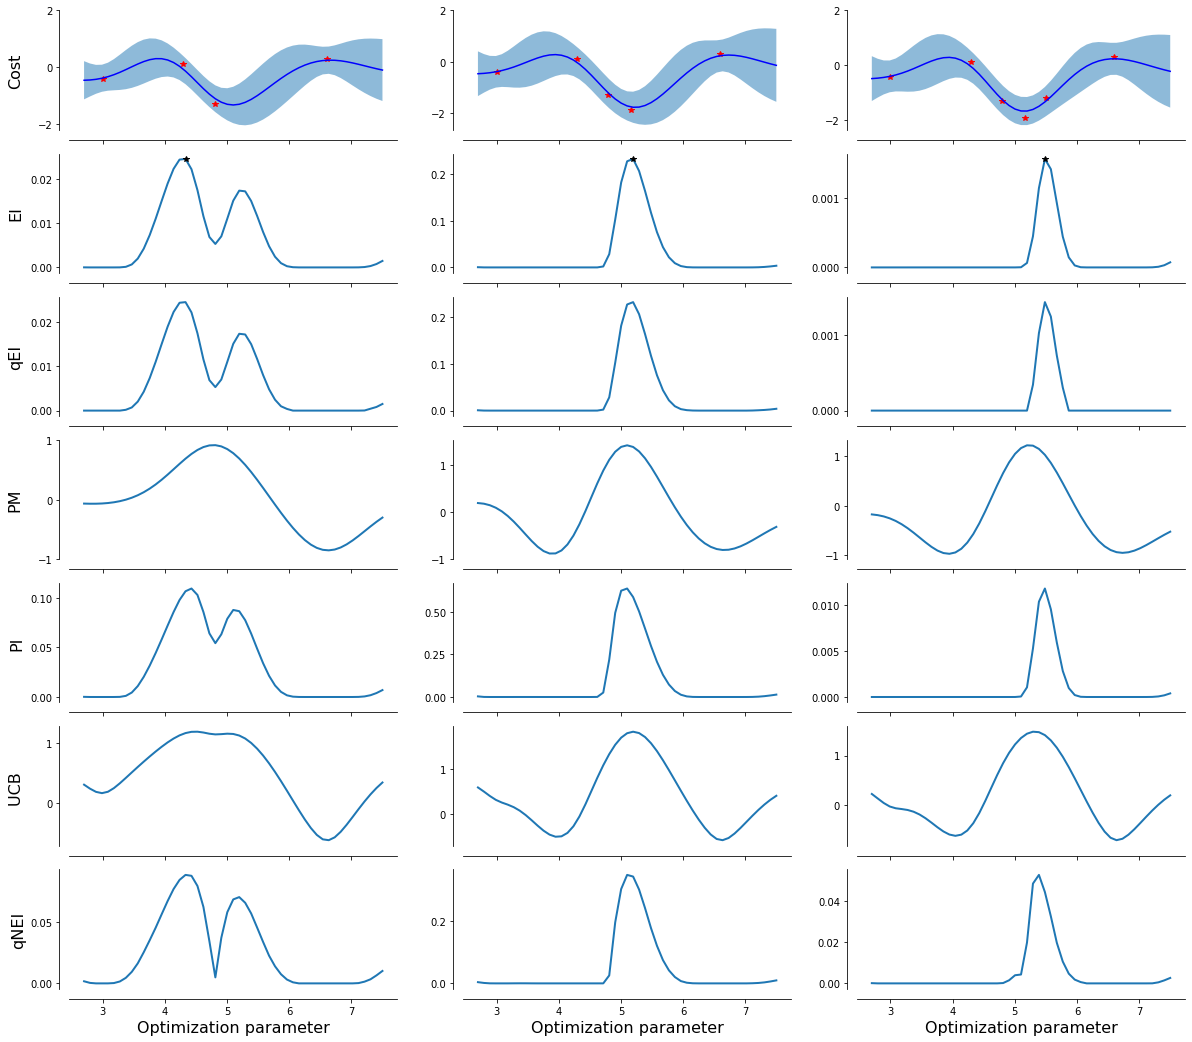

In [28]:
add_noise=0.05
qNEI = qNoisyExpectedImprovement
qEI = qExpectedImprovement
EI=ExpectedImprovement
PM=PosteriorMean
PI=ProbabilityOfImprovement
UCB=UpperConfidenceBound
labels=["Cost","Expected Improvement","Probability Of Improvement","qNoisy Expected Improvement","Posterior Mean"]
acqui_func={'EI':EI,'qEI':qEI,'PM':PM,'PI':PI,'UCB':UCB,'qNEI':qNEI}
BOUNDS=torch.tensor([[2.7],[7.5]])
raw_x = draw_sobol_samples(bounds=BOUNDS, n=3, q=1,seed=30).squeeze(1).reshape(3,1)
raw_x=torch.tensor([3,4.8,6.6]).view(3,1)
train_y=f(raw_x)
fig, ax = plt.subplots(7, 3, figsize=(20, 18))
for i in range(3,7):
    print(i)
    model=fit_model(raw_x,train_y,50)
    # model.likelihood.noise=0.1
    model.eval()
    likelihood=model.likelihood
    likelihood.eval()
    with torch.no_grad():
        test_x = torch.linspace(2.7,7.5, 51)
        #print(test_x.shape)
        observed_pred = likelihood(model(test_x))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        model_mean = observed_pred.mean.squeeze(-1)*model.Y_std + model.Y_mean
        lower=lower*model.Y_std + model.Y_mean
        upper=upper*model.Y_std + model.Y_mean
        # Plot training data as red stars
        #plt.cla()
        if i>=4:
            ax[0,i-4].plot(raw_x.numpy(), -train_y.numpy(), 'r*',label='observed data',linewidth=2)
            ax[0,i-4].plot(test_x.numpy(), -model_mean[0,:], 'b',label='mean')
            ax[0,i-4].fill_between(test_x.cpu().numpy(), -lower.cpu().numpy()[-1,:],
             -upper.cpu().numpy()[-1,:], alpha=0.5,label='confidence')
            ax[0,0].set_ylabel('Cost',fontsize=16)
            ax[6,i-4].set_xlabel("Optimization parameter",fontsize=16)
            ax[0,i-4].set_yticks([-2,0,2])
            ax[0,i-4].set_xticklabels([])
            ax[0,i-4].spines['right'].set_visible(False)
            ax[0,i-4].spines['top'].set_visible(False)
            ax[0,i-4].spines['left'].set_position(('outward', 10))
            ax[0,i-4].spines['bottom'].set_position(('outward', 10))
        # plt.plot(raw_x.numpy(), train_y.numpy(), 'r*',label='observed data',linewidth=2)
        # # Plot predictive means as blue line
        # plt.plot(test_x.numpy(), model_mean[0,:], 'b',label='mean')
        # # plt.plot(test_x.numpy(), lower[0,:])
        # # plt.plot(test_x.numpy(), upper[0,:])
        # # Shade between the lower and upper confidence bounds
        # # plt.fill_between(test_x.numpy(), upper[:,0],
        # #         lower[:,0], alpha=0.5,label='confidence')

        # plt.fill_between(test_x.cpu().numpy(), lower.cpu().numpy()[-1,:],
        #      upper.cpu().numpy()[-1,:], alpha=0.5,label='confidence')
        # plt.ylabel('Cost')
        # plt.xlabel("Optimization parameter")
        # plt.legend()
        # plt.show()
    if i<6:
        for j,expl in enumerate(acqui_func.keys()):
            sampler_qnei = SobolQMCNormalSampler(num_samples=512)
            if expl == 'EI':
                aq = acqui_func[expl](model, best_f=train_y.max())
                ax[j+1,0].set_ylabel("EI",fontsize=16)
                candidate, acq_value = optimize_acqf(
                            acq_function=aq,
                            bounds=torch.tensor([[2.7],[7.5]]),
                            #bounds=BOUNDS,
                            q=1,
                            num_restarts=10,
                            raw_samples=512,
                            sequential=True
                            )
            elif expl=='PI':
                aq = acqui_func[expl](model, best_f=train_y.max())
                ax[j+1,0].set_ylabel("PI",fontsize=16)
                ax[j+1,i-3].set_xticklabels([])
            elif expl=='qNEI':
                aq = acqui_func[expl](model,X_baseline=raw_x,sampler=sampler_qnei)
                ax[j+1,0].set_ylabel("qNEI",fontsize=16)
            elif expl =='PM':
                aq = acqui_func[expl](model)
                ax[j+1,0].set_ylabel("PM\n",fontsize=16)
                ax[j+1,i-4].set_yticks([-1,0,1])
                ax[j+1,i-3].set_xticklabels([])
            elif expl=='qEI':
                aq = acqui_func[expl](model,best_f=train_y.max(),sampler=sampler_qnei)
                ax[j+1,0].set_ylabel("qEI",fontsize=16)
                ax[j+1,i-3].set_xticklabels([])
            elif expl=='UCB':
                aq = acqui_func[expl](model, beta=1)
                ax[j+1,0].set_ylabel("UCB \n",fontsize=16)
                ax[j+1,i-3].set_xticklabels([]) 
            #print("here")
            #print(expl)
            #print(acq_value)
            ax[j+1,i-3].locator_params(axis='y',tight=True,nbins=3)
            ax[j+1,i-3].plot(test_x.detach(),aq(test_x.unsqueeze(-1).unsqueeze(-1)).detach(),linewidth=2)
            ax[j+1,i-3].spines['right'].set_visible(False)
            ax[j+1,i-3].spines['top'].set_visible(False)
            ax[j+1,i-3].spines['left'].set_position(('outward', 10))
            ax[j+1,i-3].spines['bottom'].set_position(('outward', 10))            
            if expl == 'EI':
                aq = acqui_func[expl](model, best_f=train_y.max())
                max=aq(test_x.unsqueeze(-1).unsqueeze(-1)).detach().max()
                maxi=aq(test_x.unsqueeze(-1).unsqueeze(-1)).detach().argmax()
                ax[j+1,i-3].set_xticklabels([])
                ax[j+1,i-3].plot(test_x[maxi],max,'k*')
                ax[j+1,i-3].spines['right'].set_visible(False)
                ax[j+1,i-3].spines['top'].set_visible(False)
                ax[j+1,i-3].spines['left'].set_position(('outward', 10))
                ax[j+1,i-3].spines['bottom'].set_position(('outward', 10))
                candidate, acq_value = optimize_acqf(
                            acq_function=aq,
                            bounds=torch.tensor([[2.7],[7.5]]),
                            #bounds=BOUNDS,
                            q=1,
                            num_restarts=10,
                            raw_samples=256,
                            sequential=True
                            )
    else:
        aq = acqui_func['EI'](model, best_f=train_y.max())     
        # plt.show()
        candidate, acq_value = optimize_acqf(
                                acq_function=aq,
                                bounds=torch.tensor([[2.7],[7.5]]),
                                #bounds=BOUNDS,
                                q=1,
                                num_restarts=10,
                                raw_samples=512,
                                sequential=True
                                )
    new_x = candidate.detach()
    new_y_noiseless = f(new_x)
    #new_y_noiseless=f(new_x)
    new_y = new_y_noiseless + add_noise*torch.randn_like(new_y_noiseless)
    # update training points
    raw_x = torch.cat((raw_x, new_x))
    train_y = torch.cat((train_y, new_y))
ax[0, 0].yaxis.set_label_coords(-0.14, 0.5)
ax[1, 0].yaxis.set_label_coords(-0.14, 0.5)
ax[2, 0].yaxis.set_label_coords(-0.14, 0.5)
ax[3, 0].yaxis.set_label_coords(-0.09, 0.5)
ax[4, 0].yaxis.set_label_coords(-0.135, 0.5)
# ax[6, 0].yaxis.set_label_coords(-0.1, 0.5)
# ax[3, 0].yaxis.set_label_coords(-0.04, 0.5)

# ax[0, 0].yaxis.set_label_coords(-0.1, 0.5)
# ax[0, 0].yaxis.set_label_coords(-0.1, 0.5)
# ax[0, 0].yaxis.set_label_coords(-0.1, 0.5)
# ax[0, 0].yaxis.set_label_coords(-0.1, 0.5)
# ax[0, 0].yaxis.set_label_coords(-0.1, 0.5)
#plt.savefig(f'fw_figures/subplot5.pdf',format='pdf',bbox_inches='tight',dpi=300)
plt.show()

In [145]:
def fit_model2(raw_x,train_y,train_iter,lr=0.01):
    Y_mean = train_y.mean(dim=-2, keepdim=True)
    Y_std = train_y.std(dim=-2, keepdim=True)
    model = SingleTaskGP(raw_x, (train_y-Y_mean)/Y_std,covar_module=ScaleKernel(base_kernel=RBFKernel(
            lengthscale_constraint=Interval(0.0001,2)),outputscale_constraint=Interval(0.0001,1)))
    model.likelihood=GaussianLikelihood(noise_prior=NormalPrior(0.05,0.01),noise_constraint=Interval(0.0001,0.1))
    # model = SingleTaskGP(raw_x, (train_y-Y_mean)/Y_std,covar_module=ScaleKernel(base_kernel=RBFKernel()))
    # model.likelihood=GaussianLikelihood()
    model.Y_mean=Y_mean
    model.Y_std=Y_std
    # print(model.covar_module.base_kernel.lengthscale,"length")
    # print(model.covar_module.outputscale,"out")
    # print(model.likelihood.noise)
    #outp,noises,lengthscale=training1(model,model.likelihood,train_iter,raw_x, (train_y - Y_mean)/Y_std,lr)
    #mll= ExactMarginalLogLikelihood(model.likelihood, model).to(raw_x)
    #fit_gpytorch_model(mll,max_retries=5)
    # print(model.covar_module.base_kernel.lengthscale,"length")
    # print(model.covar_module.outputscale,"out")
    # print(model.likelihood.noise)
    return model

In [149]:
def fit_model1(raw_x,train_y,train_iter,lr=0.01):
    Y_mean = train_y.mean(dim=-2, keepdim=True)
    Y_std = train_y.std(dim=-2, keepdim=True)
    model = SingleTaskGP(raw_x, (train_y-Y_mean)/Y_std,covar_module=ScaleKernel(base_kernel=RBFKernel(
            lengthscale_constraint=Interval(0.0001,1.6)),outputscale_constraint=Interval(0.0001,1.2)))
    model.likelihood=GaussianLikelihood(noise_prior=NormalPrior(0.05,0.01),noise_constraint=Interval(0.0001,0.1))
    # model = SingleTaskGP(raw_x, (train_y-Y_mean)/Y_std,covar_module=ScaleKernel(base_kernel=RBFKernel()))
    # model.likelihood=GaussianLikelihood()
    model.Y_mean=Y_mean
    model.Y_std=Y_std
    # print(model.covar_module.base_kernel.lengthscale,"length")
    # print(model.covar_module.outputscale,"out")
    # print(model.likelihood.noise)
    outp,noises,lengthscale=training1(model,model.likelihood,train_iter,raw_x, (train_y - Y_mean)/Y_std,lr)
    #mll= ExactMarginalLogLikelihood(model.likelihood, model).to(raw_x)
    #fit_gpytorch_model(mll,max_retries=5)
    # print(model.covar_module.base_kernel.lengthscale,"length")
    # print(model.covar_module.outputscale,"out")
    # print(model.likelihood.noise)
    return model,outp,noises,lengthscale

3


<Figure size 432x288 with 0 Axes>

tensor([[4.3117]])
4


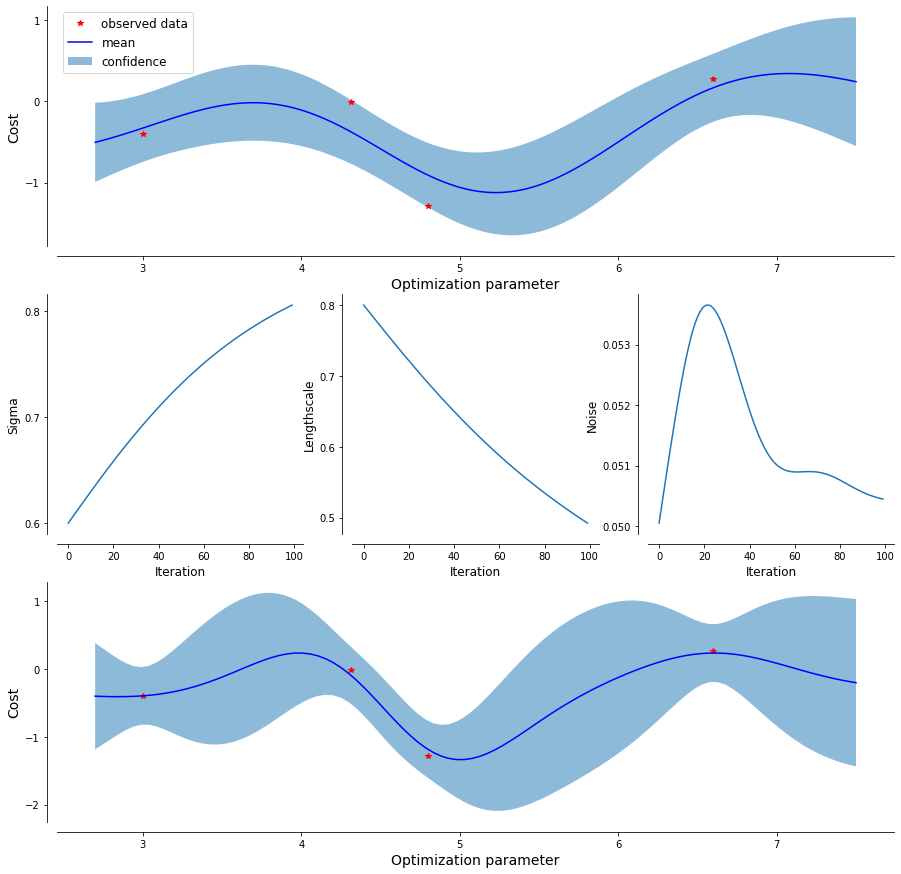

tensor([[5.0816]])


In [177]:
np.random.seed(100)
add_noise=0.05
qNEI = qNoisyExpectedImprovement
qEI = qExpectedImprovement
EI=ExpectedImprovement
PM=PosteriorMean
PI=ProbabilityOfImprovement
labels=["Cost","Expected Improvement","Probability Of Improvement","qNoisy Expected Improvement","Posterior Mean"]
acqui_func={'EI':EI}#,'qEI':qEI,'PM':PM,'PI':PI,}
BOUNDS=torch.tensor([[2.7],[7.5]])
raw_x = draw_sobol_samples(bounds=BOUNDS, n=1, q=3,seed=320).squeeze(1).reshape(3,1)
raw_x=torch.tensor([3,4.8,6.6]).view(3,1)
train_y=f(raw_x)+add_noise*torch.randn_like(raw_x)

for i in range(3,5):
    print(i)
    model_pre=fit_model2(raw_x,train_y,100,0.01)
    model,outp,noises,lengthscale=fit_model1(raw_x,train_y,100,0.01)
    # model.likelihood.noise=0.1

    if i==4:
        fig = plt.figure(figsize=(15, 15))
        ax1= fig.add_subplot(3,1,1)
        ax2= fig.add_subplot(3,3,4)
        ax3= fig.add_subplot(3,3,5)
        ax4= fig.add_subplot(3,3,6)
        ax5= fig.add_subplot(3,1,3)
        ax2.plot(outp)
        ax4.plot(noises)
        ax3.plot(lengthscale)
    model.eval()
    likelihood=model.likelihood
    likelihood.eval()
    model_pre.eval()
    likelihood_pre=model_pre.likelihood
    likelihood_pre.eval()
    with torch.no_grad():
        test_x = torch.linspace(2.7,7.5, 100)
        #print(test_x.shape)
        observed_pred = likelihood_pre(model_pre(test_x))
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        model_mean = observed_pred.mean.squeeze(-1)*model.Y_std + model.Y_mean
        lower=lower*model.Y_std + model.Y_mean
        upper=upper*model.Y_std + model.Y_mean

        ax1.plot(raw_x.numpy(), -train_y.numpy(), 'r*',label='observed data',linewidth=2)
        ax1.plot(test_x.numpy(), -model_mean[0,:], 'b',label='mean')
        ax1.fill_between(test_x.cpu().numpy(), -lower.cpu().numpy()[-1,:],
             -upper.cpu().numpy()[-1,:], alpha=0.5,label='confidence')


        observed_pred = likelihood(model(test_x))
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        model_mean = observed_pred.mean.squeeze(-1)*model.Y_std + model.Y_mean
        lower=lower*model.Y_std + model.Y_mean
        upper=upper*model.Y_std + model.Y_mean
        # Plot training data as red stars
        #plt.cla()
        #fig,ax=plt.subplots()
        
        ax5.plot(raw_x.numpy(), -train_y.numpy(), 'r*',linewidth=2)
        ax5.plot(test_x.numpy(), -model_mean[0,:], 'b')
        # ax.plot(test_x.numpy(), -lower[0,:],'k')
        # ax.plot(test_x.numpy(), -upper[0,:],'k')
        ax5.fill_between(test_x.cpu().numpy(), -lower.cpu().numpy()[-1,:],
             -upper.cpu().numpy()[-1,:], alpha=0.5,label='confidence')
        axes=[ax1,ax2,ax3,ax4,ax5]
        for ax in axes:
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_position(('outward', 10))
            ax.spines['bottom'].set_position(('outward', 10))
            if ax!=ax1 or ax!=ax5:
                ax.locator_params(axis='y',tight=True,nbins=4)
            else:
                ax.locator_params(axis='y',tight=True,nbins=4) 
                ax.locator_params(axis='x',tight=True,nbins=3)
        ax2.set_ylabel("Sigma",fontsize=12)
        ax3.set_ylabel("Lengthscale",fontsize=12)
        ax4.set_ylabel("Noise",fontsize=12)
        ax4.set_xlabel("Iteration",fontsize=12)
        ax3.set_xlabel("Iteration",fontsize=12)
        ax2.set_xlabel("Iteration",fontsize=12)
        ax1.set_xlabel("Optimization parameter",fontsize=14)
        ax5.set_xlabel("Optimization parameter",fontsize=14)
        ax1.set_ylabel("Cost",fontsize=14)
        ax5.set_ylabel("Cost",fontsize=14)
        # Shade between the lower and upper confidence bounds
        # plt.fill_between(test_x.numpy(), upper[:,0],
        #         lower[:,0], alpha=0.5,label='confidence')

        ax1.legend(loc='upper left',fontsize=12)
        # plt.ylabel('Cost',fontsize=16)
        # plt.xlabel("Optimization parameter",fontsize=16)
        #plt.legend()
        #plt.savefig(f'fw_figures/mattern_{i}.pdf',format='pdf',bbox_inches='tight')
        #plt.savefig(f'fw_figures/Hyper_parameter.pdf',format='pdf',bbox_inches='tight',dpi=400)
        plt.show()
        mu = -model_mean[0,30]
        sigma=upper[0,30]-model_mean[0,30]
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        #plt.plot(x, stats.norm.pdf(x, mu, sigma))
        # plt.fill_betweenx(stats.norm.pdf(x, mu, sigma),x,alpha=0.4)
        # plt.plot([mu,mu], [0,stats.norm.pdf(x, mu, sigma).max()],linestyle='--',color='r')
        #plt.savefig(f'fw_figures/rq_{i}_dist.pdf',format='pdf',bbox_inches='tight')
        #plt.show()
    for j,expl in enumerate(acqui_func.keys()):
        sampler_qnei = SobolQMCNormalSampler(num_samples=512)
        if expl == 'EI':
            aq1 = acqui_func[expl](model, best_f=train_y.max())
        elif expl=='qEI':
            aq1 = acqui_func[expl](model,best_f=train_y.max(),sampler=sampler_qnei)
            #ax[j+1,0].set_ylabel("MC based\nExpected\nImprovement",fontsize=14)
        #print("here")
        #print(expl)
        #print(acq_value)   
    # plt.show()
    candidate, acq_value = optimize_acqf(
                            acq_function=aq1,
                            bounds=torch.tensor([[2.7],[7.5]]),
                            #bounds=BOUNDS,
                            q=1,
                            num_restarts=15,
                            raw_samples=256,
                            sequential=False
                            )
    print(candidate)
    new_x = candidate.detach()
    new_y_noiseless = f(new_x)
    #new_y_noiseless=f(new_x)
    new_y = new_y_noiseless + add_noise*torch.randn_like(new_y_noiseless)
    # update training points
    raw_x = torch.cat((raw_x, new_x))
    train_y = torch.cat((train_y, new_y))
#plt.show()

### matlab

In [2]:
from scipy.io import loadmat
import os

In [ ]:
print(os.listdir('../../continuous_opt_study/sub-P003/ses-S002/runs.txt'))

In [3]:
opt1 = loadmat('../../continuous_opt_study/sub-P003/afo_device/FileScopeLog-20220817-141106.mat')

In [17]:
opt1['HumotechData'][0,0]['data'][:,31]

array([1.15565121, 1.06378142, 0.93684918, ..., 1.77167618, 1.77745252,
       1.78525575])

In [ ]:
for i in opt1['HumotechData'][0,0]['data'][:,]